# Gaussian Mixture Models

A notebook by Christoph Carl Kling, datascience ät c-kling.de

GESIS - Leibniz Institute for the Social Sciences

http://www.c-kling.de

This work is licensed under a Creative Commons Attribution 4.0 International License:
https://creativecommons.org/licenses/by/4.0/

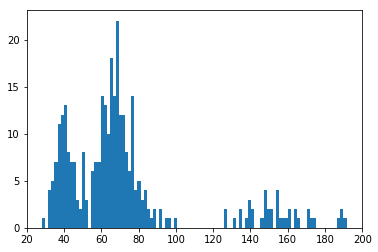

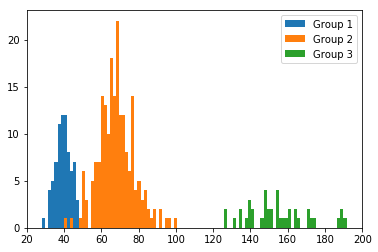

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from scipy import stats
import scipy
import sklearn.mixture as mix
import random

#number of clusters
c = 3;
#cluster sizes
c_len = [80,200,40];
#cluster means
c_mean = [40,70,150];
#cluster standard deviations
c_std = [5, 10, 15];

#arrays for samples
#X holds the sample values
X = [];
#y[i] in {0,...,c} has the sample ID for the ith value
y = [];

#create samples: Add values to X, add sample IDs to y
for i in range(0,c):
    random_samples = stats.norm(c_mean[i],c_std[i]).rvs(c_len[i]);
    X.extend(random_samples);
    y.extend([i]*c_len[i]);
    
#plot
bins = np.linspace(min(X), max(X), 100)

#we convert y and X to numpy arrays
y=np.array(y);
X=np.array(X);

plt.hist(X,bins=bins); 
plt.show();

plt.hist(X[y == 0],bins=bins);
plt.hist(X[y == 1],bins=bins);
plt.hist(X[y == 2],bins=bins);

plt.legend(["Group 1","Group 2", "Group 3"]);

In [2]:
#calculate means of clusters given cluster assignments z
#z is an array for each observation, which is 0 except for 
#the index of the cluster, at which it is 1
#for three clusters it could look like [[0,0,1],[1,0,0],[1,0,0],[0,1,0],...]
def means(X, z,k):
    mu = [0]*k;
    count = [0]*k;
    n = len(z);
    for i in range(0,n):
        for j in range(0,k):
            mu[j] = mu[j] + z[i][j] * X[i]
            count[j] = count[j]+z[i][j]
    for i in range(0,k):
        mu[i] = mu[i] / count[i];           
    return mu

#k-means. Parameters:
#X: array of values
#k: number of clusters
#iterations: number of iterations, we do a silly variant
#smarter variants could stop if clusters converge
def k_means(X, k, iterations=20):
    mu = stats.norm(0,1).rvs(k);
    sigma =[1]*k;
    n = len(y);
    #z stores the cluster assignments
    #z is 0 except for the selected class, where it is 1
    #we initialise with random values 
    #(draw each one sample from a uniform multinomial)
    z = np.random.multinomial(1, [1/k]*k, size=n);
    
    for iteration in range(0,iterations):
        #re-calculate means
        mu = means(X, z, k)
        #for each value in X:
        for i in range(0,n):
            dist = [0]*k   
            #get the distance of X[i] to each cluster
            #and calculate the min
            for j in range(0,k):
                dist[j] = abs(X[i]-mu[j]);
                dist_min = np.argmin(dist);
            z[i] = [0]*k;
            #assign value 1 to the index of the
            #minimum value
            z[i][dist_min] = 1; 
        print("run",iteration);
        
    cluster_idx = np.array([0]*n);
    #create array which contains the IDs of
    #assigned clusters, e.g. {2,0,0,1,...}
    for i in range(0,n):
        cluster_idx[i] = np.argmax(z[i]);
        
    return cluster_idx, mu, z;

In [3]:
cl, mu, _ = k_means(X, 3, 10);

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


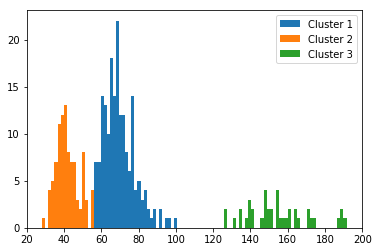

In [4]:
plt.hist(X[cl == 0],bins=bins);
plt.hist(X[cl == 1],bins=bins);
plt.hist(X[cl == 2],bins=bins);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);

In [5]:
#estimate standard deviations for each cluster
#based on values X, cluster assignments z, means
#mu (an array) and number of clusters k
def sigmas(X, z,mu,k):
    sigma = [0]*k;
    count = [0]*k;
    n = len(z);
    for i in range(0,n):
        for j in range(0,k):
            sigma[j] = sigma[j] +  z[i][j] * (mu[j] - X[i])**2
            count[j] = count[j]+z[i][j]
    for i in range(0,k):
        sigma[i] = np.sqrt(sigma[i] / count[i])
        #troubleshooting 
        if np.isnan(sigma[i]):
            sigma[i]=1;
    return sigma

#estimate the probabilities of each cluster
#(multinomial distribution with parameter pi)
def pis(z):
    pi = np.array(np.sum(z, axis=0));
    pi = np.divide(pi,np.sum(pi));
    return pi

#Gaussian Mixture Model (GMM) Parameters:
#X: array of values
#k: number of clusters
#iterations: number of iterations, we do a silly variant:
#smarter variants could stop if clusters converge
def gmm_1(X, k, iterations=20):
    mu = stats.norm(0,1).rvs(k);
    sigma =[1]*k;
    n = len(y);
    #z stores the cluster assignments
    #z is 0, except for the selected class, where it is 1
    #we initialise with random values 
    #(draw each one sample from a uniform multinomial)
    z = np.random.multinomial(1, [1/k]*k, size=n);
    
    for iteration in range(0,iterations):
            
        #Estimate cluster parameters
        mu = means(X, z, k)
        sigma = sigmas(X, z, mu, k)
        #Estimate cluster probabilities
        pi = pis(z);
               
        for i in range(0,n):
            pdf = [0]*k
            #get relative probability of X[i] under each cluster
            #and calculate the max
            for j in range(0,k):
                pdf[j] = pi[j] * scipy.stats.norm.pdf(X[i],mu[j],sigma[j])
            pdf_max = np.argmax(pdf);
            z[i] = [0]*k;
            z[i][pdf_max] = 1; 
        print("run",iteration);
        
    cluster_idx = np.array([0]*n);
    #create array which contains the IDs of
    #assigned clusters, e.g. {2,0,0,1,...}
    for i in range(0,n):
        cluster_idx[i] = np.argmax(z[i]);
        
    return cluster_idx, mu, sigma;

In [6]:
cl_gmm_1, mu, s = gmm_1(X, 3, 20);

run 0
run 1
run 2
run 3


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19


mus: [nan, 71.909628064594784, nan]
sigmas [1, 34.847784750663742, 1]


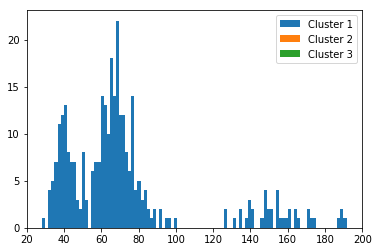

In [7]:
plt.hist(X[cl_gmm_1 == 0],bins=bins);
plt.hist(X[cl_gmm_1 == 1],bins=bins);
plt.hist(X[cl_gmm_1 == 2],bins=bins);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);

print("mus:",mu);
print("sigmas", s);

### Normal-Inverse Gamma Prior
Parameters: 
* $\lambda$
* $\mu_0$
* $\alpha_0$
* $\beta_0$

Mean was estimated from $\lambda$ observations with sample mean $\mu_0$;

Variance was estimated from $2\alpha_0$ observations with sample mean $\mu_0$ and sum of squared deviations $2\beta_0 \qquad$ ( = $\sum_{i=1}^n (x_{i} - \mu_0)^2 $)

#### Posterior of a normal-gamma distribution

$\mathbf{P}(\tau, \mu | \mathbf{X}) = \text{NormalGamma}\left(\frac{\lambda_0 \mu_0 + n \bar{x}}{\lambda_0 + n}, \lambda_0 + n, \alpha_0+\frac{n}{2}, \beta_0+ \frac{1}{2}\left(n \cdot s + \frac{\lambda_0 n (\bar{x} - \mu_0 )^2}{\lambda_0 +n} \right) \right)$

with

$s = \frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^2 $

#### Maximum A-Posteriori inference (MAP)
We use the mode of the normal-gamma distribution for parameter inference:

$\hat X_{\text{MAP}}=\mu\,\! ,\quad \hat \tau_{\text{MAP}}= (\alpha - 1/2) \cdot \beta^{-1}$

$\sigma^2 = \frac{1}{\tau}$

In [8]:
#Estimate cluster probabilities with
#symmetric Dirichlet prior with parameter alpha
#using maximum a-posteriori estimation
def pis_dir(z,alpha=1.0):
    k = len(z[0]);
    pi = np.double(np.sum(z, axis=0));
    #sum of counts and pseudo-counts
    pi_sum = np.sum(pi) + k*alpha -k;
    #normalise
    for i in range(0,k):
        pi[i] = (pi[i] + alpha -1)/pi_sum;
    return pi
    
#Estimate normal distribution parameters
#with normal-inverse gamma prior
#using maximum a-posteriori estimation
#(this is just a one-to-one translation of the formula
#above)
def mu_sigma_ng(X, z, mu0 = 0, lambda0=1, alpha0=0.5, beta0=0.5):
    n = len(z);
    k = len(z[0]);
    mu = [0]*k;
    sigma = [0]*k;
    count = [0]*k;
    sums = [0]*k;
    square = [0]*k;
    
    for i in range(0,n):
        for j in range(0,k):
            sums[j] = sums[j] + (z[i][j] * X[i]);
            count[j] = count[j]+z[i][j];
            
    for i in range(0,k):
        mu[i] = (lambda0*mu0 + sums[i])/(lambda0+count[i]);
        if count[i] == 0 | np.isnan(mu[i]):
            mu[i] = mu0;
          
    for i in range(0,n):
        for j in range(0,k):
            square[j] = square[j] +  (z[i][j] * ((mu[j] - X[i])**2));           

    beta = [beta0]*k;
            
    for i in range(0,k):
        lambda_ = lambda0+count[i];
    
        alpha = alpha0+(count[i]/2);
    
        beta[i] = beta[i] + (1/2)*(square[i] + ((lambda0*count[i])*((mu0-mu[i])**2)) / (lambda0+count[i]))
              
        if (alpha>1/2):
            tau = (alpha - 1/2)/beta[i];
            sigma[i] = np.sqrt(1 / (tau));
        else:
            sigma[i] = np.sqrt(beta0/(2*alpha0));

    return mu, sigma, sums, count

In [9]:
#Gaussian Mixture Model (GMM) Parameters:
#X: array of values
#k: number of clusters
#iterations: number of iterations, we do a silly variant:
#smarter variants could stop if clusters converge
#alpha_dir: symmetric Dirichlet prior
#mu0, lambda0, alpha0, beta0: normal-inverse gamma prior
def gmm_2(X, k, iterations=20, alpha_dir=1, mu0 = 0, lambda0=1, alpha0=0.5, beta0=0.5):
 
    mu = stats.norm(0,1).rvs(k);
    sigma =[1]*k;
    
    n = len(y);
    pi = [1.0/k]*k;
    
    #z stores the cluster assignments
    #z is 0, except for the selected class, where it is 1
    #we initialise with random values 
    #(draw each one sample from a uniform multinomial)
    z = np.random.multinomial(1, [1/k]*k, size=n);
    #Alternative: Init with k-means
    #_, _, z = k_means(X, k, 10);    
    
    for iteration in range(0,iterations):    
        
        logLik = 0;
        mu, sigma, _, _ = mu_sigma_ng(X, z, mu0, lambda0, alpha0, beta0)
        
        #mu = means(X, z, k)
        #sigma = sigmas(X, z, mu, k)
        
        pi = pis_dir(z, alpha_dir);
        
        for i in range(0,n):
            pdf = [0]*k
            #get relative probability of X[i] under each cluster
            #and calculate the max
            for j in range(0,k):
                pdf[j] = np.log(pi[j]) + scipy.stats.norm.logpdf(X[i],mu[j],sigma[j]);
            pdf_max = np.argmax(pdf);
            logLik+=pdf[pdf_max];
            z[i] = [0]*k;
            z[i][pdf_max] = 1;   
        
        print("run",iteration,"log likelihood",logLik); 
    
        
    cluster_idx = np.array([0]*n);
    
    for i in range(0,n):
        cluster_idx[i] = np.argmax(z[i]);
        
    return cluster_idx, mu, sigma;

In [10]:
mu0 = np.average(X);
lambda0 = 1;
alpha0 = 0.5;
beta0 = np.var(X)*2*alpha0;    
   
alpha_dir = 2;   
cl_gmm_2, mu, s = gmm_2(X, 3, 20, alpha_dir, mu0, lambda0, alpha0, beta0);

run 0 log likelihood -1872.45601212
run 1 log likelihood -1463.71990144
run 2 log likelihood -1454.74214951
run 3 log likelihood -1453.56857543
run 4 log likelihood -1453.56857543
run 5 log likelihood -1453.56857543
run 6 log likelihood -1453.56857543
run 7 log likelihood -1453.56857543
run 8 log likelihood -1453.56857543
run 9 log likelihood -1453.56857543
run 10 log likelihood -1453.56857543
run 11 log likelihood -1453.56857543
run 12 log likelihood -1453.56857543
run 13 log likelihood -1453.56857543
run 14 log likelihood -1453.56857543
run 15 log likelihood -1453.56857543
run 16 log likelihood -1453.56857543
run 17 log likelihood -1453.56857543
run 18 log likelihood -1453.56857543
run 19 log likelihood -1453.56857543


mus: [60.135886159978504, 71.909628064594813, 152.60283477672098]
sigmas [15.529818389526021, 34.847784750663742, 22.275124094476478]


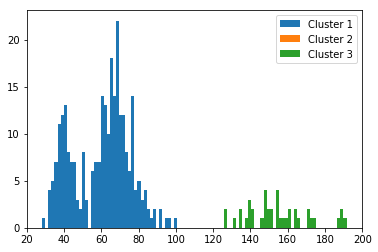

In [11]:
plt.hist(X[cl_gmm_2 == 0],bins=bins);
plt.hist(X[cl_gmm_2 == 1],bins=bins);
plt.hist(X[cl_gmm_2 == 2],bins=bins);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);

print("mus:",mu);
print("sigmas", s);

In [12]:
#The following functions were not used yet -- they 
#are alternatives to the MAP estimates defined before

#Estimate cluster probabilities with
#symmetric Dirichlet prior with parameter alpha
#using Bayesian inference 
def pis_dir_bayes(z,alpha=1.0):
    k = len(z[0]);
    pi = np.double(np.sum(z, axis=0));
    #sum of counts and pseudo-counts
    pi_sum = np.sum(pi) + k*alpha;
    #normalise
    for i in range(0,k):
        pi[i] = (pi[i] + alpha)/pi_sum;
    return pi
  
#Estimate normal distribution parameters
#with normal-inverse gamma prior
#using Bayesian inference (I looked up the expectation of
#the NG distribution)
#(this is just a one-to-one translation of the formula
#above)
def mu_sigma_ng_bayes(X, z, mu0 = 0, lambda0=1, alpha0=0.5, beta0=1):
    n = len(z);
    k = len(z[0]);
    mu = [0]*k;
    sigma = [0]*k;
    count = [0]*k;
    sums = [0]*k;
    square = [0]*k;
    
    for i in range(0,n):
        for j in range(0,k):
            sums[j] = sums[j] + (z[i][j] * X[i]);
            count[j] = count[j]+z[i][j];
            
    for i in range(0,k):
        mu[i] = (lambda0*mu0 + sums[i])/(lambda0+count[i]);
        if count[i] == 0 | np.isnan(mu[i]):
            mu[i] = mu0;
          
    for i in range(0,n):
        for j in range(0,k):
            square[j] = square[j] +  (z[i][j] * ((mu[j] - X[i])**2));           

    beta = [beta0]*k;
            
    for i in range(0,k):
        lambda_ = lambda0+count[i];
    
        alpha = alpha0+(count[i]/2);
    
        beta[i] = beta[i] + (1/2)*(square[i] + ((lambda0*count[i])*((mu0-mu[i])**2)) / (lambda0+count[i]))
              
        if (alpha>0):
            tau = (alpha)/beta[i];
            sigma[i] = np.sqrt(1 / (lambda_ * tau));
        else:
            sigma[i] = np.sqrt(beta0/(2*alpha0));

        #if (np.isnan(sigma[i])):
        #    sigma[i] = np.sqrt((1/2)*beta0);

    return mu, sigma, sums, count

In [13]:
#Sample from the posterior of the Dirichlet-multinomial
#distribution
def pis_dir_sample(z,alpha=1.0):
    k = len(z[0]);
    pi = np.double(np.sum(z, axis=0));
    #normalise
    pi = np.random.dirichlet(pi+[alpha]*k);
    return pi

#Sample from a normal-gamma distribution
#(posterior of the normal-inverse gamma dist.)
#See Wikipedia for the formulas
def mu_sigma_ng_sample(X, z, mu0 = 0, lambda0=1, alpha0=0.5, beta0=0.5):
    n = len(z);
    k = len(z[0]);
    mu = [0]*k;
    sigma = [0]*k;
    count = [0]*k;
    sums = [0]*k;
    square = [0]*k;
    
    for i in range(0,n):
        for j in range(0,k):
            sums[j] = sums[j] + (z[i][j] * X[i]);
            count[j] = count[j]+z[i][j];
            
    for i in range(0,k):
        mu[i] = (lambda0*mu0 + sums[i])/(lambda0+count[i]);
        if count[i] == 0 | np.isnan(mu[i]):
            mu[i] = mu0;
          
    for i in range(0,n):
        for j in range(0,k):
            square[j] = square[j] +  (z[i][j] * ((mu[j] - X[i])**2));           

    beta = [beta0]*k;
            
    for i in range(0,k):
        lambda_ = lambda0+count[i];
    
        alpha = alpha0+(count[i]/2);
    
        beta[i] = beta[i] + (1/2)*(square[i] + ((lambda0*count[i])*((mu0-mu[i])**2)) / (lambda0+count[i]))

        tau = np.random.gamma(alpha,1.0/beta[i]);
                           
        sigma[i] = np.sqrt(1 / (tau));
                           
        mu[i] = np.random.normal(mu[i], 1 / (lambda_ * tau));

    return mu, sigma, sums, count

In [14]:
#Sample from multinomial with parameters
#proportional to the given log of parameters x
def random_log(x):
    k=len(x);
    x_sum = np.sum(np.exp(x));
    if (x_sum==0):
        x = [np.log(1.0/k)]*k;
        x_sum = 1;
    log_x_sum = np.log(x_sum);
    
    for i in range(0,len(x)):
        x[i] = x[i]-log_x_sum;
    
    rand = np.random.rand();
    x = np.exp(x);
    
    for i in range(1,len(x)):
        x[i] = x[i] + x[i-1];
    
    for i in range(0,len(x)):
        if rand <= x[i]: 
            return i

def normalise(x):
    x_sum = np.sum(x);
    if (x_sum <= 0 | np.isnan(x_sum)):
        k = len(x);
        #random multinomial from uniform Dirichlet
        return np.random.dirichlet([1]*k);
    else:
        for i in range(0,len(x)):
            if np.isnan(x[i]):
                x[i]=0;
            x[i] = x[i]/x_sum;
    return x;

def normalise_log(x):
    exp_x = np.exp(x);
    log_x_sum = np.log(np.sum(exp_x));
    if (log_x_sum <= 0 | np.isnan(log_x_sum)):
        k = len(x);
        max_idx = np.argmax(x);
        x = [0]*k;
        x[max_idx]=1;
        #random multinomial from uniform Dirichlet
        return x;
    else:
        for i in range(0,len(x)):
            if np.isnan(x[i]):
                x[i]=0;
            x[i] = x[i]-log_x_sum;
    return np.exp(x);

#Gibbs sampler for Bayesian GMM
def gmm_gibbs(X, k, iterations=20, burnin = 10, alpha_dir = 1, mu0 = 0, lambda0=1, alpha0=0.5, beta0=0.5):
    n = len(y);
    #z stores the cluster assignments
    #z = np.random.multinomial(1, [1/k]*k, size=n);
    
    #z stores the cluster assignments
    #we can initialise with k means
    _, _, z = k_means(X, k, 10);
    
    pdf = [0.0]*k;
    
    mu_sum = [0.0]*k;
    sigma_sum = [0.0]*k;
    pi_sum = [0.0]*k;
    
    for iteration in range(0,iterations):

        #update cluster parameters
        mu,sigma,_,_ = mu_sigma_ng_sample(X,z, mu0, lambda0,alpha0,beta0);
        pi = pis_dir_sample(z, alpha_dir);
        
        #After burnin phase: calculate sum of paramters
        #so that we later divide by the iterations to get
        #an estimate of the expecation of the posterior
        if (iteration >= burnin):
            mu_sum = np.add(mu_sum,mu);
            sigma_sum = np.add(sigma_sum, sigma);
            pi_sum = np.add(pi_sum, pi);
                            
        #update cluster assignments
        for i in range(0,n):
            #remove old assignment
            z[i] = [0]*k;
            #get relative probability of X[i] under each cluster
            #and calculate the max
            for j in range(0,k):
                pdf[j] = np.log(pi[j]) + scipy.stats.norm.logpdf(X[i],mu[j],sigma[j]);
            #if i%10 == 0:
            #    print(pdf)
            newz = random_log(pdf);
            #add new assignment
            z[i][newz] = 1;
            #print(newz, z[i])
            #update cluster parameters
            #mu = means(X, z, k)
            #sigma = sigmas(X, z, mu, k)     
            #mu,sigma,_,_ = mu_sigma_ng(X,z);

        if (iteration%10 == 0):
            print("run",iteration)#, mu, sigma, sigmas(X,z,mu,k));
        
    cluster_idx = np.array([0]*n);
    
    for i in range(0,n):
        cluster_idx[i] = np.argmax(z[i]);
    
    #calculate average parameter settings
    #as an estimate of Bayesian inference
    expect_mu = np.divide(mu_sum, [(iterations - burnin)]*k);
    expect_sigma = np.divide(sigma_sum, [(iterations-burnin)]*k);
    expect_pi = np.divide(pi_sum, [(iterations-burnin)]*k);
        
    return cluster_idx, expect_mu, expect_sigma, expect_pi;

In [15]:
mu0 = np.average(X);
lambda0 = 1;
alpha0 = 0.5;
beta0 = np.var(X)*alpha0;
alpha_dir = 0.0001;

cl_gmm_gibbs, mu, s, pi = gmm_gibbs(X, 3, 100, 80, alpha_dir, mu0, lambda0, alpha0, beta0);

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 0
run 10
run 20
run 30
run 40
run 50
run 60
run 70
run 80
run 90


mus: [  42.76206132   68.4139967   148.98128699]
sigmas [  8.49302014   9.60714935  26.46806497]
pis [ 0.28472316  0.58083096  0.13444589]


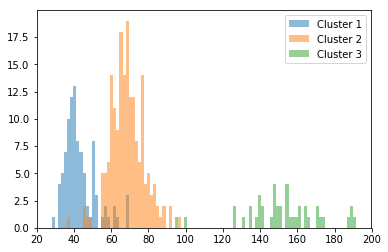

In [16]:
plt.hist(X[cl_gmm_gibbs == 0],bins=bins,alpha=0.5);
plt.hist(X[cl_gmm_gibbs == 1],bins=bins,alpha=0.5);
plt.hist(X[cl_gmm_gibbs == 2],bins=bins,alpha=0.5);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);

print("mus:",mu);
print("sigmas", s);
print("pis", pi);

In [55]:
#okay, now we go totally crazy and sample our
#normal distributions from a Dirichlet process
#and create a gibbs sampler to estimate used normal
#distribution behind each observation. The infrence
#is based on the Chinese restaurant representation
#(we send customers out and let them enter again
#each time we re-estimate a z)
def igmm_gibbs(X, iterations=20, burnin = 10, alpha_dp = 1, mu0 = 0, lambda0=1, alpha0=0.5, beta0=0.5):
    
    n = len(y);
    
    #inititally, there are no clusters (tables)
    k=0;
    
    #number of elements assigned to clusters
    #(customers at tables) is initially an empty
    #array
    nk = [0]*k;    
    
    #k+1 options: k used categories, one for a new table
    pdf = [0.0]*(k+1);
    
    #This is a Gibbs sampler. So we again use
    #the sums of parameters and later divide by
    #iterations-burnin to get the average, an
    #estimator for the expectation of the posterior
    #over the model parameters
    mu_sum = [[]];
    sigma_sum = [[]];
    exp_sum = [];
    z=[];
        
    #colours of clusters for barchart
    colours = [];
    #the colours are from a colour map with
    #num_colours colours
    num_colours = 10;
    colour_map = plt.cm.get_cmap("Vega10",num_colours);
    #I store how many different clusters every existed
    #for the colourmap
    k_total = 0;
    
    std_normal = scipy.stats.norm;
    #This is the expected normal distribution
    #given by the prior distribution
    pdf_prior = scipy.stats.norm(mu0,np.sqrt(beta0/alpha0));
    
    for iteration in range(0,iterations):
   
        #update cluster assignments
        for i in range(0,n):            
            old_idx = -1;
            if (iteration > 0):
                #remove old assignment
                old_idx = np.argmax(z[i]);
                nk[old_idx] = nk[old_idx] - 1;
                z[i] = [0]*k;
                
                #remove empty clusters
                if (nk[old_idx]==0):
                    print("del",old_idx, "\t", nk);
                    mu = np.delete(mu,old_idx,axis=0);
                    sigma = np.delete(sigma,old_idx,axis=0);
                    mu_sum = np.delete(mu_sum,old_idx,axis=0);
                    sigma_sum = np.delete(sigma_sum,old_idx,axis=0);
                    nk=np.delete(nk,old_idx,axis=0);
                    z=np.delete(z,old_idx,axis=1);
                    exp_sum=np.delete(exp_sum,old_idx,axis=0);
                    colours=np.delete(colours,old_idx,axis=0);
                    k = k-1; 
                    
            #get relative probability of X[i] under each cluster
            #and calculate the max
            pdf = [0.0]*(k+1);
            for j in range(0,k):
                pdf[j] = np.log(nk[j]) + std_normal.logpdf(X[i],mu[j],sigma[j]);
            pdf[k]= np.log(alpha_dp) + pdf_prior.logpdf(X[i]);
            z_idx = random_log(pdf);
            
            if (z_idx == k):
                #add new cluster
                k = k+1;
                k_total = k_total+1;
                #If there was no cluster yet,
                #initialise z
                if (k==1):
                    z=[[0]]*n;
                    z[i][z_idx]=1;
                else:
                    new_z=np.zeros((n,k));
                    new_z[:,:-1] = z;
                    z=new_z;
                    z[i][z_idx]=1;
                                
                #add new cluster to parameters
                new_nk=np.zeros(k).astype(int);
                new_nk[:-1]=nk;
                nk = new_nk;
                nk[z_idx]=1;
                mu_sum_new = np.zeros((k,1));
                mu_sum_new[:-1] = mu_sum;
                mu_sum = mu_sum_new;
                sigma_sum_new = np.zeros((k,1));
                sigma_sum_new[:-1]=sigma_sum;
                sigma_sum = sigma_sum_new;
                exp_sum_new = np.zeros(k);
                exp_sum_new[:-1] = exp_sum;
                exp_sum = exp_sum_new;
                new_colours = [""]*k;
                new_colours[:-1] = colours;
                new_colours[-1]=colour_map(k_total%num_colours);
                colours = new_colours;
                                
                #mu,sigma,_,count = mu_sigma_ng_sample(X, z, mu0, lambda0,alpha0,beta0);
                mu_new,sigma_new,_,_ = mu_sigma_ng_sample(X, [np.array(z)[:,-1]], mu0, lambda0,alpha0,beta0);
                
                #If there was no cluster yet,
                #initialise mu, sigma
                if (k==1):
                    mu = mu_new;
                    sigma = sigma_new;
                else:
                    mu_newer = np.zeros(k);
                    mu_newer[:-1] = mu;
                    mu = mu_newer;
                    sigma_newer = np.zeros(k);
                    sigma_newer[:-1] = sigma;
                    sigma = sigma_newer;
                    mu[-1]=mu_new[0];
                    sigma[-1]=sigma_new[0];
                print("add", k, "\t", nk);               

            else:
                #modify existing cluster
                z[i][z_idx] = 1;
                nk[z_idx]=nk[z_idx]+1;
            #print(newz, z[i])
            #update cluster parameters
            #mu = means(X, z, k)
            #sigma = sigmas(X, z, mu, k)     
            #mu,sigma,_,_ = mu_sigma_ng(X,z);       
            
        #update cluster parameters
            mu,sigma,_,_ = mu_sigma_ng_sample(X, z, mu0, lambda0,alpha0,beta0);
        
        #add parameter to sum for the final estimation
        if (iteration >= burnin):
            for j in range(0,k):
                mu_sum[j]= mu_sum[j]+mu[j];
                sigma_sum[j]=sigma_sum[j]+sigma[j];
                exp_sum[j]=exp_sum[j]+1;
                
        #print("run",iteration,"\t", nk);#, mu, sigma, sigmas(X,z,mu,k));
        
        #Print histogram of clusters
        
        #array of cluster assignments
        cluster_idx = np.array([0]*n);
        for i in range(0,n):
            cluster_idx[i] = np.argmax(z[i]);
            
        cluster_names=[""]*k;
        for j in range(0,k):
            cluster_names[j] = "%i"%(nk[j]);
            plt.hist(X[cluster_idx == j],bins=bins,color=colours[j],alpha=0.85);
            plt.legend(cluster_names,bbox_to_anchor=(+1.25, +1.02), loc='upper right', ncol=1);
        plt.title("Histograms of clusters after run %i"%(iteration+1));
        plt.ylim((0,15));
        plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
        plt.savefig("png/gmm%03d.png"%iteration);
        plt.show();
                    
    
    #Average of the samples of each iteration
    #is the estimate for the expectation of the
    #parameters under the true posterior of the
    #model
    expect_mu = [0]*k;
    expect_sigma = [0]*k;
    for j in range(0,k):
        expect_mu[j] = np.divide(np.sum(mu_sum[j]), exp_sum[j]);
        expect_sigma[j] = np.divide(np.sum(sigma_sum[j]), exp_sum[j]);
        
    return cluster_idx, expect_mu, expect_sigma;

add 1 	 [1]
add 2 	 [1 1]
add 3 	 [11  1  1]
add 4 	 [31  1  3  1]
add 5 	 [34  1  3  1  1]
add 6 	 [47  1  5  1  1  1]
add 7 	 [63  1  6  1  1  1  1]
add 8 	 [173   1   8   2   1   1   1   1]
add 9 	 [178   1   9   2   1   1   1   1   1]


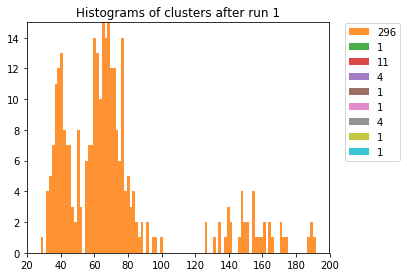

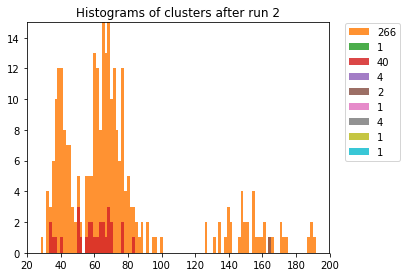

add 10 	 [250   1  55   4   2   1   4   1   1   1]


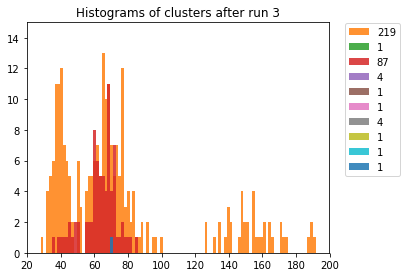

del 9 	 [179   1 125   4   1   1   6   1   1   0]


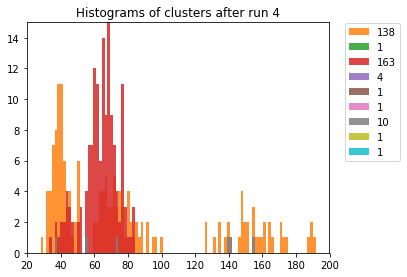

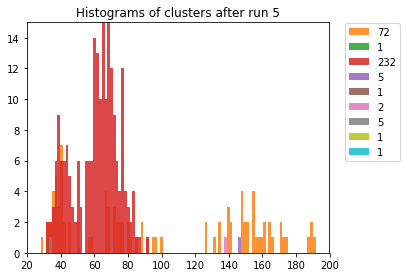

add 10 	 [ 29   1 276   4   1   2   4   1   1   1]


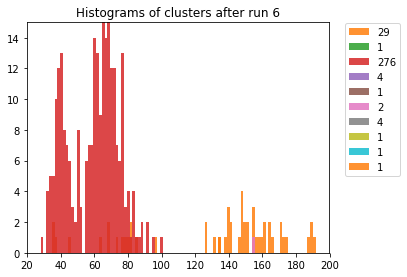

del 9 	 [ 18   1 287   4   1   2   4   1   1   0]


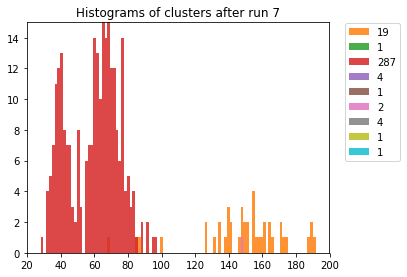

add 10 	 [ 18   1 287   4   1   2   4   1   1   1]
add 11 	 [ 13   1 290   4   1   3   4   1   1   1   1]


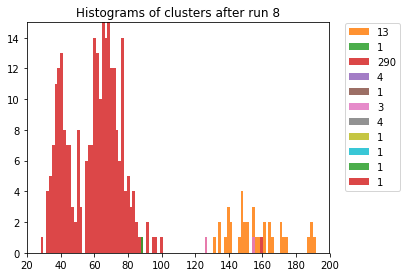

add 12 	 [ 13   1 289   4   1   3   4   1   1   1   1   1]
del 9 	 [ 13   1 289   4   1   3   4   1   1   0   1   1]
del 9 	 [ 13   1 290   4   1   3   4   1   1   0   1]


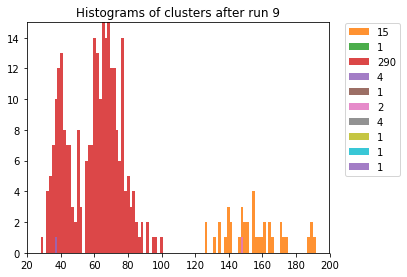

del 9 	 [ 15   1 290   4   1   2   4   1   1   0]
add 10 	 [ 15   1 290   4   1   2   4   1   1   1]


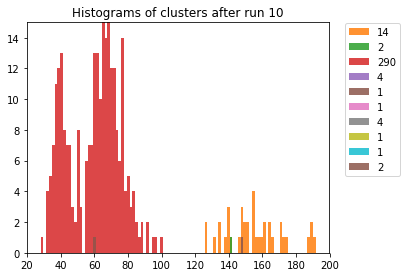

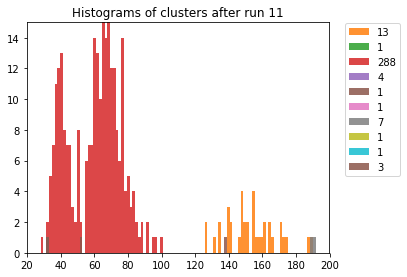

del 9 	 [ 15   1 291   4   1   1   4   1   1   0]


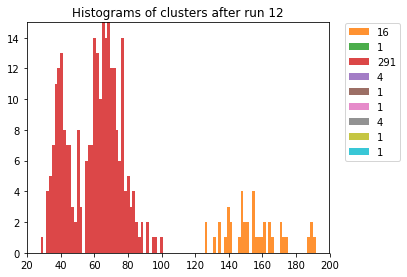

add 10 	 [ 17   1 289   4   1   1   4   1   1   1]


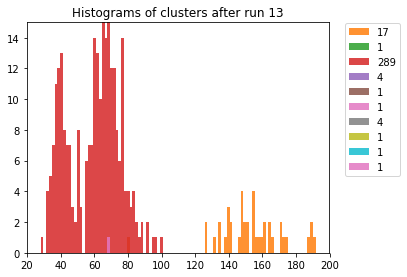

add 11 	 [ 17   1 288   4   1   1   4   1   1   1   1]
del 9 	 [ 16   1 289   4   1   1   4   1   1   0   1]


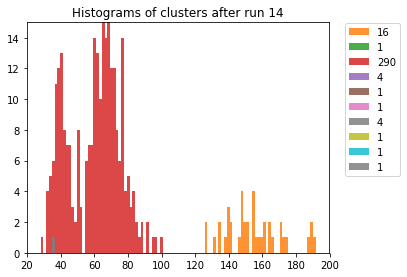

del 9 	 [ 16   1 290   4   1   1   4   1   1   0]
add 10 	 [ 16   1 290   4   1   1   4   1   1   1]


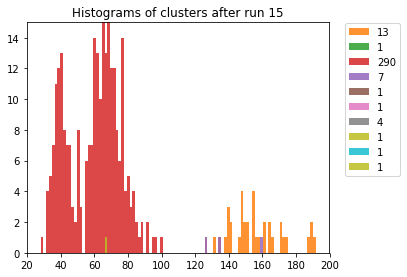

del 9 	 [ 13   1 290   7   1   1   4   1   1   0]


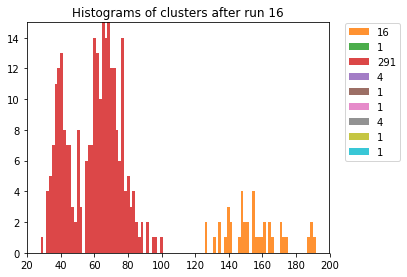

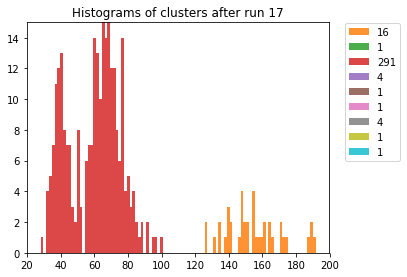

add 10 	 [ 16   1 290   4   1   1   4   1   1   1]
add 11 	 [ 16   1 289   4   1   1   4   1   1   1   1]


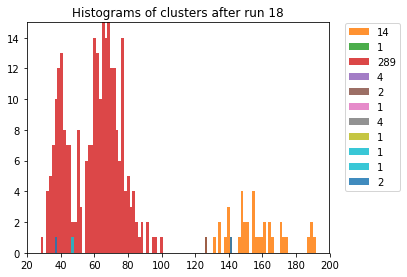

del 9 	 [ 14   1 289   4   2   1   4   1   1   0   2]
del 9 	 [ 14   1 291   4   2   1   4   1   1   0]


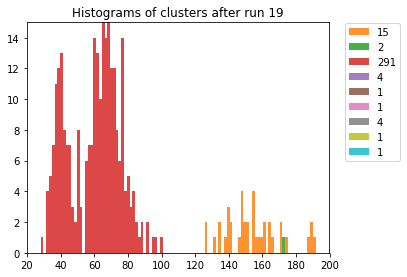

add 10 	 [ 15   2 290   4   1   1   4   1   1   1]
add 11 	 [ 15   2 289   4   1   1   4   1   1   1   1]
add 12 	 [ 15   2 287   4   1   1   5   1   1   1   1   1]
add 13 	 [ 13   2 286   4   1   1   5   1   1   3   1   1   1]


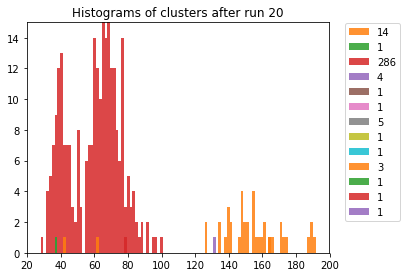

del 10 	 [ 14   1 287   4   1   1   5   1   1   2   0   1   1]
del 10 	 [ 14   1 288   4   1   1   5   1   1   2   0   1]
add 12 	 [ 14   1 288   4   1   1   5   1   1   2   1   1]
add 13 	 [ 14   1 287   4   1   1   5   1   1   2   1   1   1]
add 14 	 [ 14   1 287   4   1   1   5   1   1   1   1   1   1   1]
del 9 	 [ 14   1 287   4   1   1   5   1   1   0   1   1   1   1]
del 9 	 [ 14   1 287   4   1   1   6   1   1   0   1   1   1]


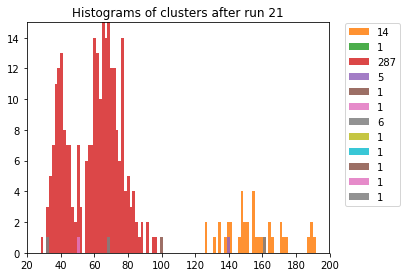

del 9 	 [ 14   1 288   5   1   1   5   1   1   0   1   1]
del 9 	 [ 14   1 289   5   1   1   5   1   1   0   1]
add 11 	 [ 14   1 289   5   1   1   5   1   1   1   1]
del 9 	 [ 14   1 289   5   1   1   5   1   1   0   1]
add 11 	 [ 14   1 289   5   1   1   5   1   1   1   1]
add 12 	 [ 12   1 289   5   1   1   4   1   1   2   2   1]


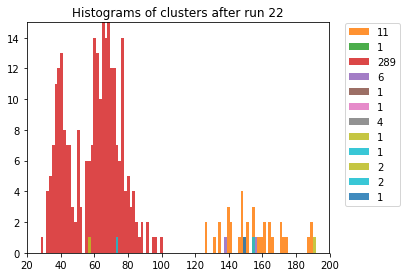

add 13 	 [ 11   1 288   6   1   1   4   1   1   2   2   1   1]
del 9 	 [ 11   1 290   6   1   1   4   1   1   0   1   1   1]
del 9 	 [ 12   1 290   6   1   1   4   1   1   0   1   1]
del 9 	 [ 12   1 290   6   1   1   4   1   1   0   2]


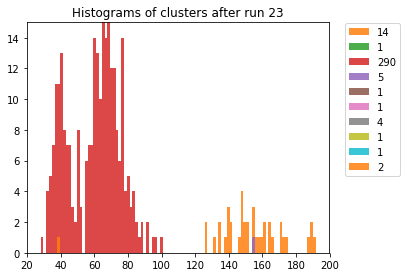

add 11 	 [ 14   1 290   5   1   1   4   1   1   1   1]
del 9 	 [ 11   1 288   5   1   2   8   1   1   0   1]
add 11 	 [ 11   1 288   5   1   2   8   1   1   1   1]


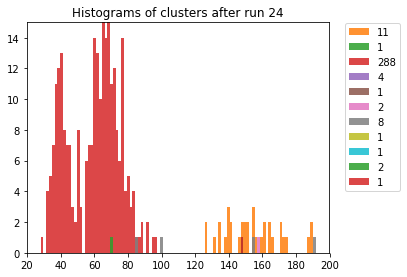

del 10 	 [ 13   1 290   4   1   1   6   1   1   1   0]
del 9 	 [ 14   1 290   4   1   1   6   1   1   0]


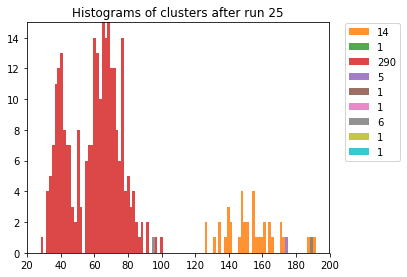

add 10 	 [ 14   1 289   5   1   1   6   1   1   1]
add 11 	 [ 14   1 290   5   1   1   4   1   1   1   1]


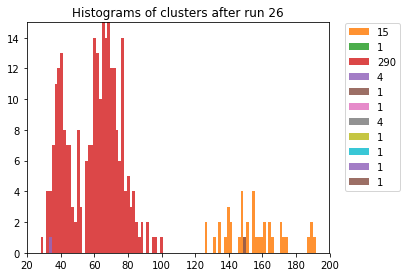

del 9 	 [ 15   1 290   4   1   1   4   1   1   0   1]
add 11 	 [ 14   1 291   4   1   1   4   1   1   1   1]
del 9 	 [ 14   1 291   4   1   1   4   1   1   0   1]


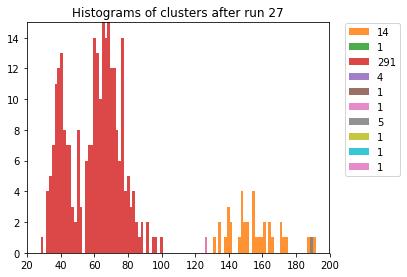

add 11 	 [ 14   1 290   4   1   1   5   1   1   1   1]
add 12 	 [ 13   1 290   4   1   1   5   1   1   1   1   1]
del 9 	 [ 13   1 290   4   1   1   5   1   1   0   1   1]
add 12 	 [ 13   1 290   4   1   1   5   1   1   1   1   1]


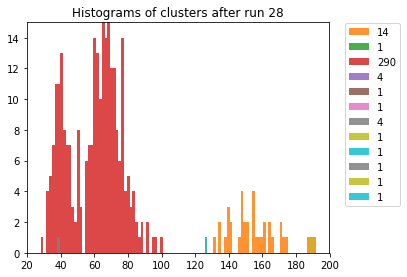

del 9 	 [ 14   1 290   4   1   1   4   1   1   0   1   1]
del 9 	 [ 14   1 291   4   1   1   4   1   1   0   1]


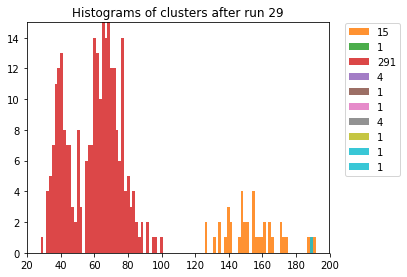

add 11 	 [ 15   1 290   4   1   1   4   1   1   1   1]
del 9 	 [ 15   1 290   4   1   1   4   1   1   0   1]


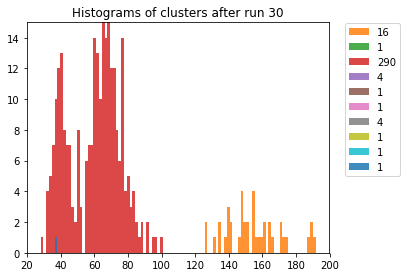

del 9 	 [ 16   1 290   4   1   1   4   1   1   0]
add 10 	 [ 16   1 290   4   1   1   4   1   1   1]
add 11 	 [ 16   1 289   4   1   1   4   1   1   1   1]
add 12 	 [ 16   1 288   4   1   1   4   1   1   1   1   1]


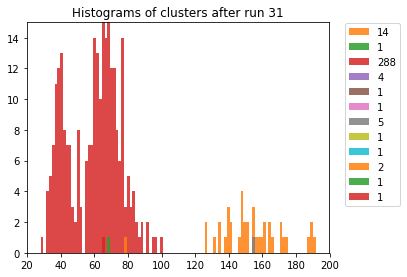

del 10 	 [ 14   1 289   4   1   1   5   1   1   1   0   1]
del 10 	 [ 14   1 290   4   1   1   5   1   1   1   0]
del 9 	 [ 12   3 291   4   1   1   5   1   1   0]


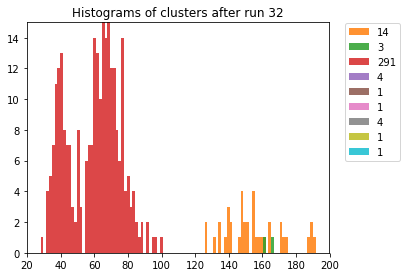

add 10 	 [ 14   3 290   4   1   1   4   1   1   1]
add 11 	 [ 14   3 289   4   1   1   4   1   1   1   1]
add 12 	 [ 13   4 287   4   1   1   4   1   1   2   1   1]


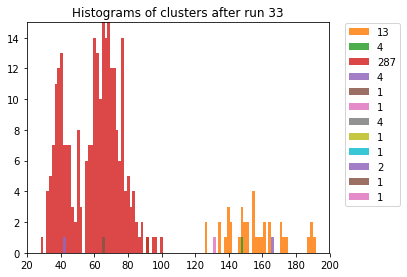

del 10 	 [ 14   4 286   4   1   1   5   1   1   1   0   1]
del 9 	 [ 15   2 288   4   1   1   5   1   1   0   1]
del 9 	 [ 16   1 288   4   1   1   6   1   1   0]


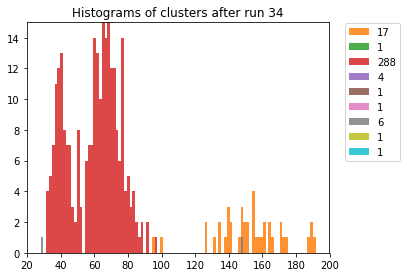

add 10 	 [ 16   1 289   4   1   1   5   1   1   1]


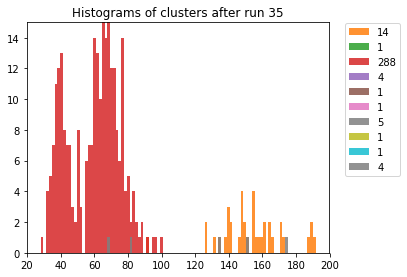

add 11 	 [ 14   1 287   4   1   1   5   1   1   4   1]
add 12 	 [ 13   1 287   4   1   1   5   1   1   4   1   1]


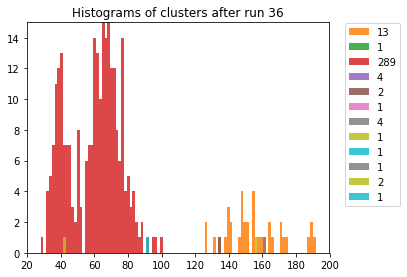

add 13 	 [ 13   1 287   4   2   1   4   1   2   1   2   1   1]
del 11 	 [ 13   1 288   4   2   1   4   1   2   1   1   0   1]
del 9 	 [ 14   1 288   4   2   1   4   1   2   0   1   1]
del 9 	 [ 14   1 288   4   2   1   4   1   3   0   1]


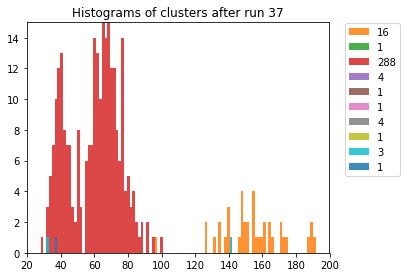

del 9 	 [ 16   1 289   4   1   1   4   1   2   0]


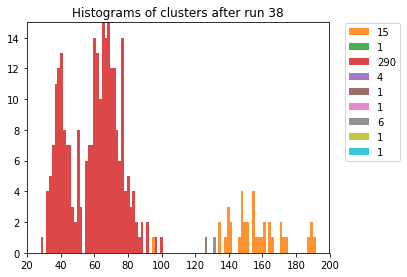

add 10 	 [ 14   1 290   4   1   1   6   1   1   1]


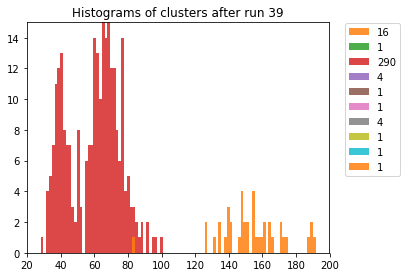

del 9 	 [ 16   1 290   4   1   1   4   1   1   0]
add 10 	 [ 15   1 291   4   1   1   4   1   1   1]


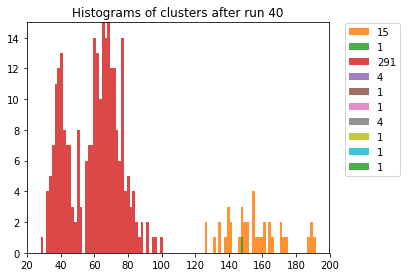

add 11 	 [ 14   1 291   4   1   1   4   1   1   1   1]
del 9 	 [ 14   1 291   4   1   1   4   1   1   0   1]


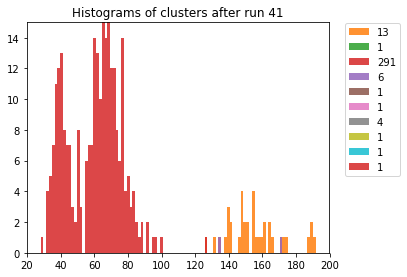

add 11 	 [ 13   1 290   6   1   1   4   1   1   1   1]
add 12 	 [ 13   1 289   6   1   1   4   1   1   1   1   1]
add 13 	 [ 13   1 288   6   1   1   4   1   1   1   1   1   1]
del 9 	 [ 12   1 287   6   2   1   4   1   1   0   1   2   1]


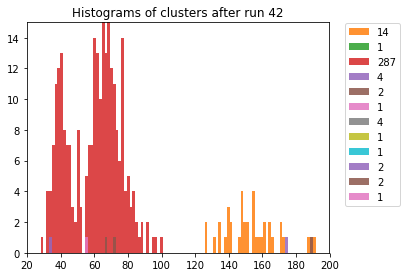

del 11 	 [ 14   1 289   4   2   1   4   1   1   1   1   0]
del 10 	 [ 14   1 291   4   1   1   4   1   1   1   0]
del 9 	 [ 15   1 291   4   1   1   4   1   1   0]
add 10 	 [ 15   1 291   4   1   1   4   1   1   1]


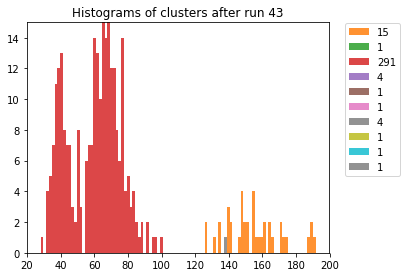

add 11 	 [ 15   1 290   4   1   1   4   1   1   1   1]
del 9 	 [ 12   2 289   6   1   1   4   1   2   0   1]


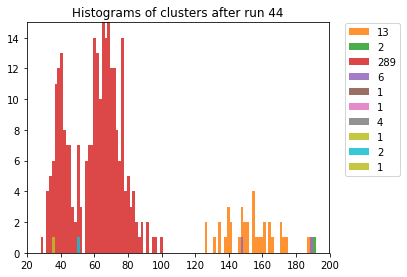

del 9 	 [ 13   2 289   6   1   1   4   1   2   0]
add 10 	 [ 14   1 290   5   1   1   5   1   1   1]


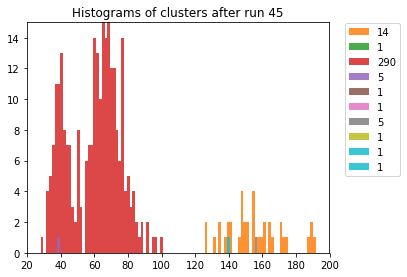

del 9 	 [ 15   1 289   6   1   1   4   1   1   0]


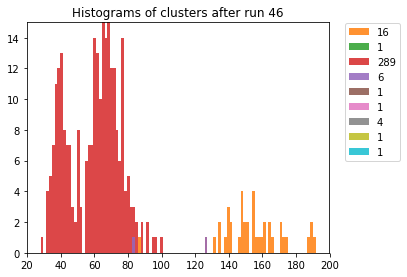

add 10 	 [ 16   1 288   6   1   1   4   1   1   1]


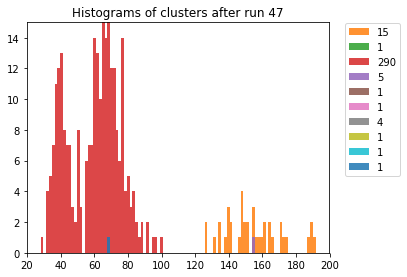

del 9 	 [ 15   1 290   5   1   1   4   1   1   0]
add 10 	 [ 15   1 290   5   1   1   4   1   1   1]


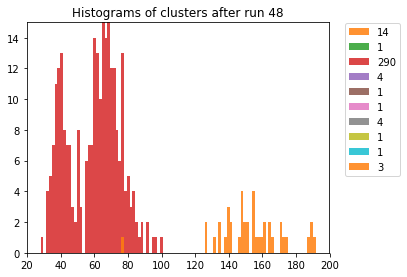

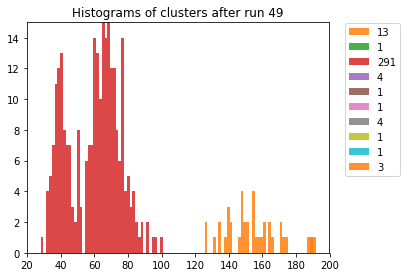

del 9 	 [ 15   1 290   4   1   1   4   1   2   0]


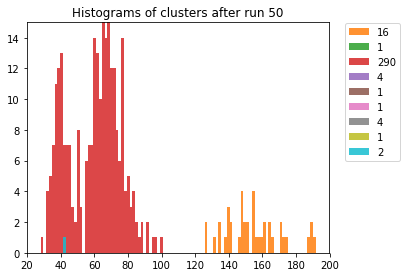

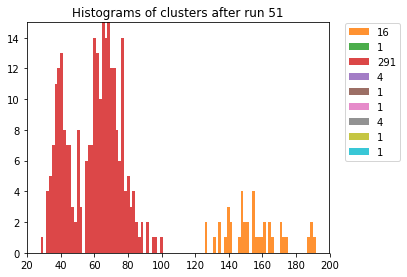

add 10 	 [ 16   1 290   4   1   1   4   1   1   1]


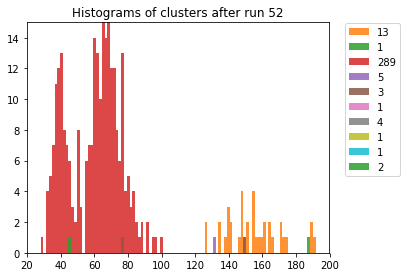

add 11 	 [ 13   1 288   5   3   2   4   1   1   1   1]
add 12 	 [ 13   1 285   6   2   4   4   1   1   1   1   1]
del 9 	 [  8   1 284   7   1   9   4   2   1   0   1   1]


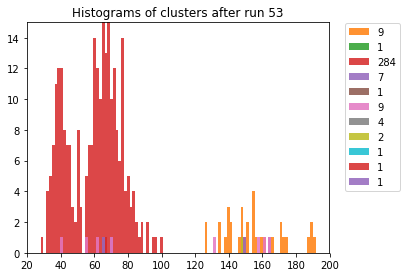

del 9 	 [  9   1 284   7   1   9   4   2   1   0   1]
del 9 	 [  9   1 280   6   1   9  10   2   1   0]
add 10 	 [ 11   1 281   4   1   7  11   2   1   1]


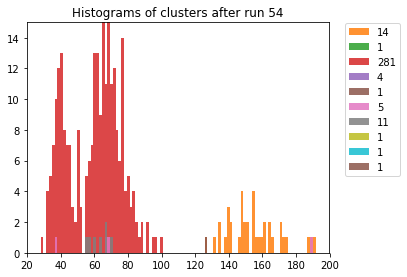

del 9 	 [ 12   1 282   5   1   2  14   1   1   0]


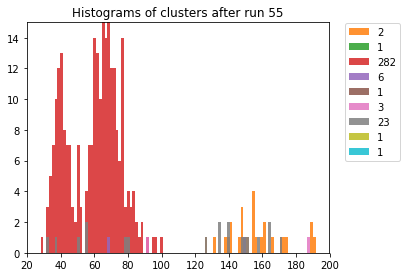

del 0 	 [  0   1 289   5   1   3  18   1   1]
del 0 	 [  0 289   5   1   3  19   1   1]
add 8 	 [289   5   1   3  19   1   1   1]
add 9 	 [288   5   1   3  19   1   1   1   1]
add 10 	 [287   5   1   3  18   1   1   2   1   1]
add 11 	 [284   5   1   3  20   1   1   2   1   1   1]
add 12 	 [282   5   1   3  21   1   1   2   1   1   1   1]
add 13 	 [281   5   1   3  21   1   1   2   1   1   1   1   1]
add 14 	 [276   4   1   3  26   1   1   2   1   1   1   1   1   1]
add 15 	 [276   4   1   3  25   1   1   2   1   1   1   1   1   1   1]


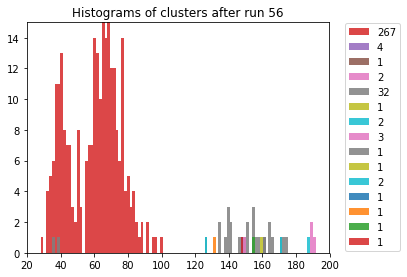

del 8 	 [267   4   1   1  32   2   2   2   0   1   2   1   1   2   1]
del 8 	 [267   4   1   1  34   2   2   1   0   2   1   1   2   1]
del 9 	 [267   4   1   1  36   2   2   1   1   0   1   2   1]
del 9 	 [267   4   1   1  37   2   2   1   1   0   2   1]
del 10 	 [267   4   1   1  38   2   2   1   1   2   0]
del 8 	 [267   4   1   1  39   3   1   1   0   2]
del 7 	 [267   4   1   1  40   3   1   0   2]


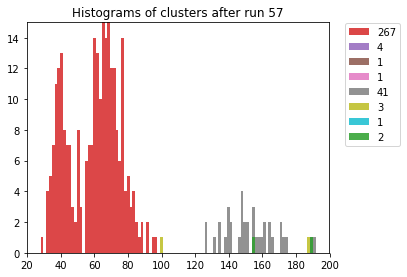

del 7 	 [267   4   1   1  43   2   1   0]


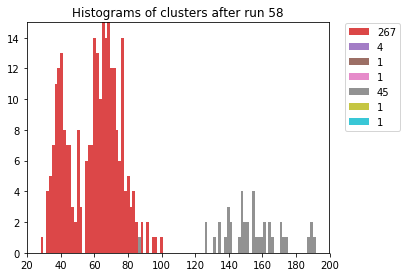

add 8 	 [266   4   1   1  45   1   1   1]
add 9 	 [259   4   1   1  51   1   1   1   1]


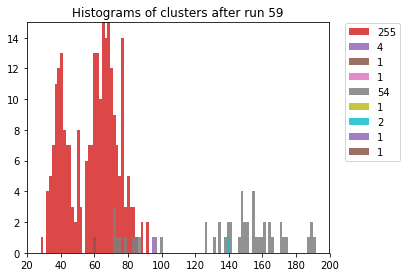

del 7 	 [252   4   1   1  56   1   3   0   1]
del 7 	 [255   4   1   1  54   1   3   0]


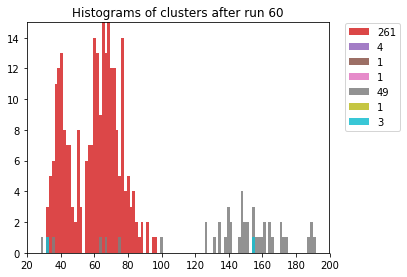

add 8 	 [265   4   1   1  45   1   2   1]
add 9 	 [265   4   1   1  44   1   2   1   1]


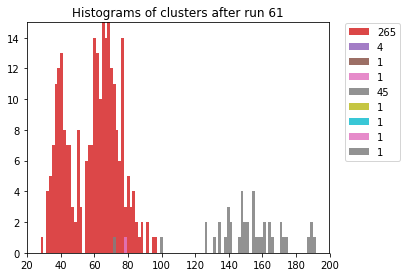

add 10 	 [264   4   1   1  45   1   1   1   1   1]
del 7 	 [263   4   1   1  45   1   1   0   1   2]
del 7 	 [263   4   1   1  46   1   1   0   2]


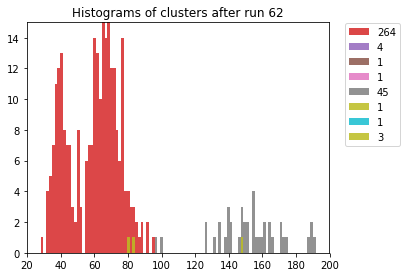

add 9 	 [263   4   1   1  45   1   1   3   1]
add 10 	 [263   4   1   1  44   1   1   3   1   1]


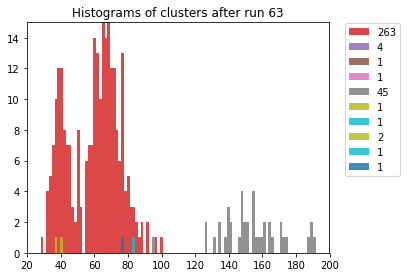

del 7 	 [264   4   1   1  45   1   1   0   1   1]
del 7 	 [266   4   1   1  44   1   1   0   1]
del 7 	 [267   4   1   1  44   1   1   0]
add 8 	 [267   4   1   1  44   1   1   1]


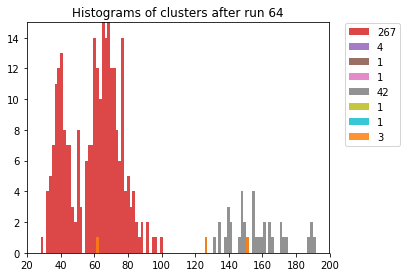

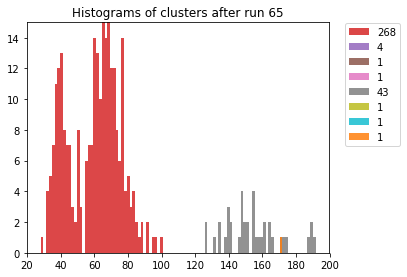

add 9 	 [267   4   1   1  43   1   1   1   1]
add 10 	 [266   4   1   1  43   1   1   1   1   1]
add 11 	 [264   4   1   1  44   1   1   1   1   1   1]
del 7 	 [264   4   1   1  44   1   1   0   1   1   1]


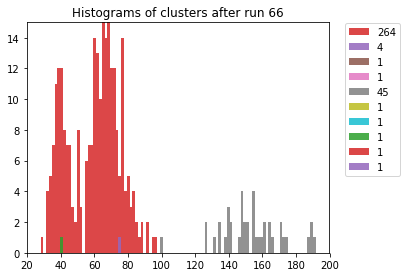

del 7 	 [264   4   1   1  45   1   1   0   1   1]
del 7 	 [265   4   1   1  45   1   1   0   1]
add 9 	 [265   4   1   1  45   1   1   1   1]
add 10 	 [264   4   1   1  45   1   1   1   1   1]
del 7 	 [264   4   1   1  45   1   1   0   1   1]
add 10 	 [264   4   1   1  45   1   1   1   1   1]


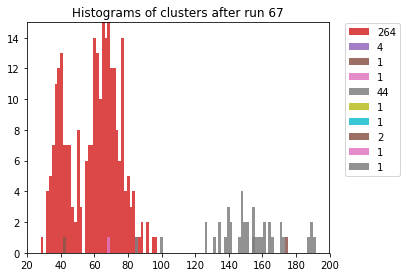

del 8 	 [263   4   1   1  46   1   1   1   0   1]
add 10 	 [260   4   1   1  49   1   1   1   1   1]
del 8 	 [259   4   1   1  50   1   1   1   0   1]
del 7 	 [259   4   1   1  51   1   1   0   1]


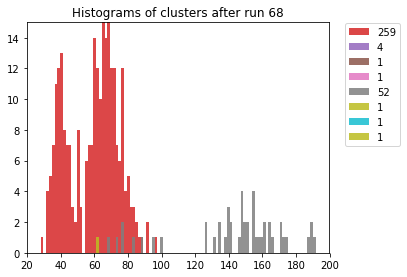

add 9 	 [257   4   2   1  52   1   1   1   1]
del 7 	 [258   4   2   1  51   1   1   0   1]


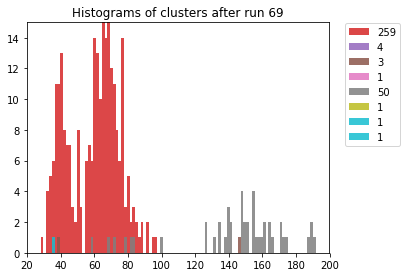

add 9 	 [259   4   2   1  50   1   1   1   1]
del 7 	 [259   4   2   1  50   1   1   0   1]


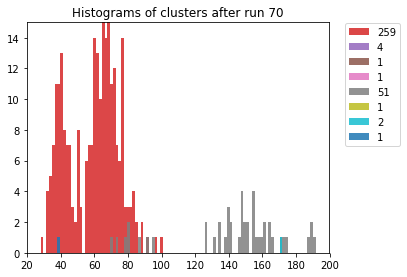

add 9 	 [257   4   1   1  52   1   2   1   1]


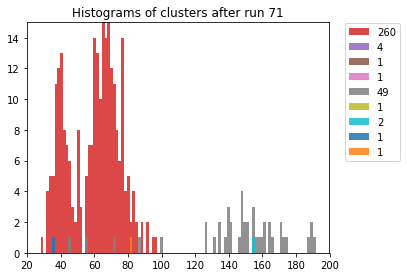

del 7 	 [261   4   1   1  48   1   2   0   1]
del 7 	 [265   4   1   1  45   1   2   0]


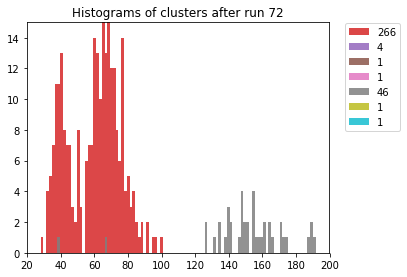

add 8 	 [265   4   1   1  46   1   1   1]


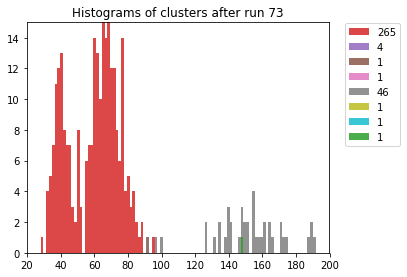

add 9 	 [264   4   1   1  46   1   1   1   1]
del 7 	 [264   4   1   1  46   1   1   0   1]


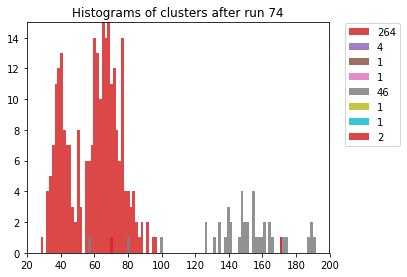

del 7 	 [259   4   1   1  52   1   1   0]


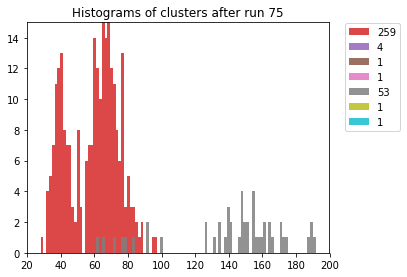

add 8 	 [257   4   1   1  54   1   1   1]


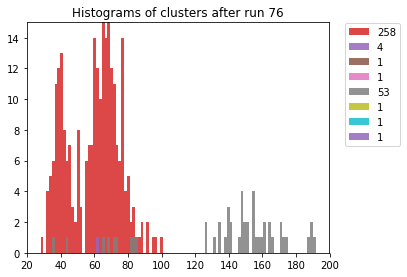

del 7 	 [256   4   1   1  55   1   1   0]


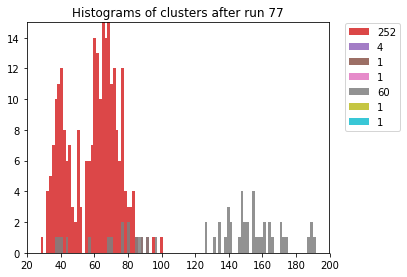

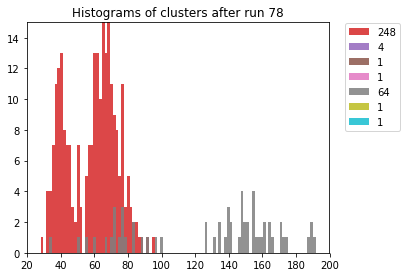

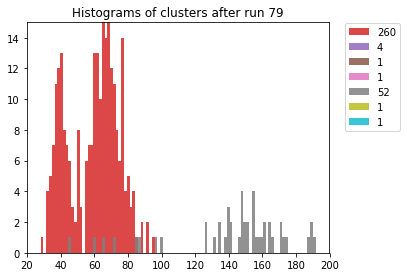

add 8 	 [260   4   1   1  51   1   1   1]
add 9 	 [259   4   1   1  51   1   1   1   1]
add 10 	 [257   4   1   1  52   1   1   1   1   1]


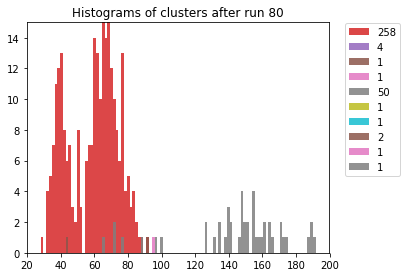

add 11 	 [255   4   1   1  52   1   1   1   1   2   1]
del 7 	 [256   4   1   1  52   1   1   0   1   1   1]
add 11 	 [256   4   1   1  52   1   1   1   1   1   1]


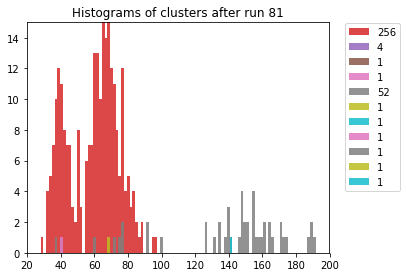

del 7 	 [257   4   1   1  51   1   1   0   1   1   1]
del 7 	 [260   4   1   1  49   1   1   0   1   1]
del 7 	 [262   4   1   1  48   1   1   0   1]
del 7 	 [266   4   1   1  45   1   1   0]


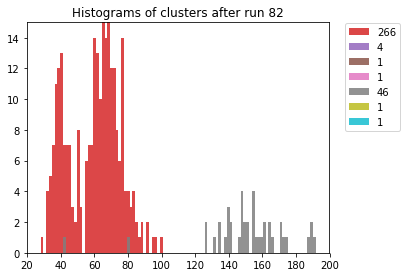

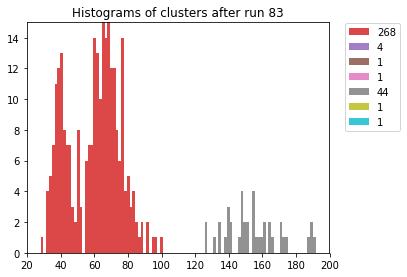

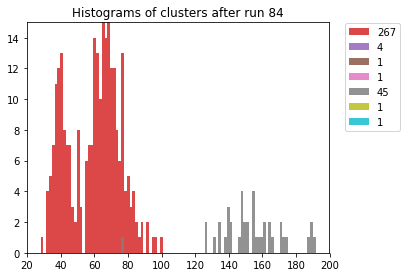

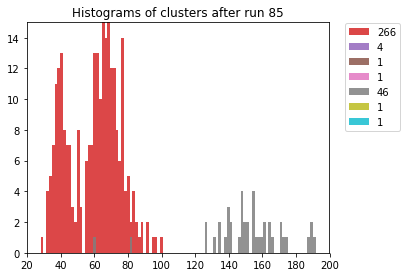

add 8 	 [267   4   1   1  44   1   1   1]


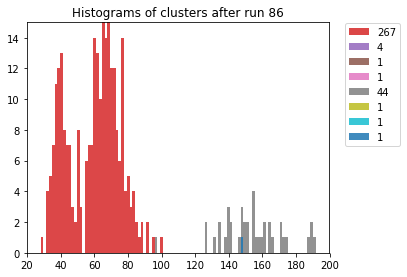

del 7 	 [268   4   1   1  43   1   1   0]
add 8 	 [268   4   1   1  43   1   1   1]


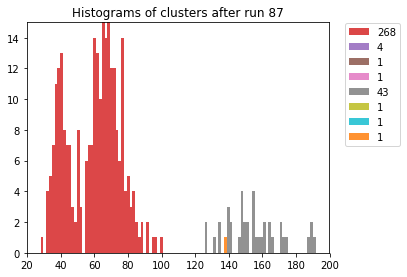

add 9 	 [267   4   1   1  43   1   1   1   1]
del 7 	 [267   4   1   1  43   1   1   0   1]


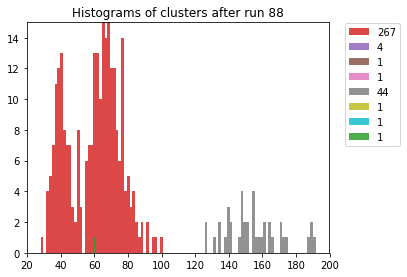

del 7 	 [266   4   1   1  45   1   1   0]


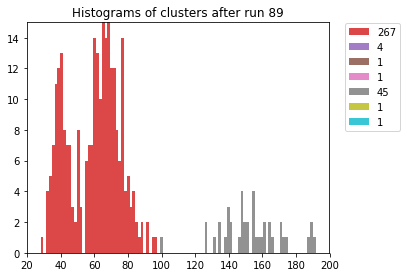

add 8 	 [266   4   1   1  45   1   1   1]
add 9 	 [266   4   1   1  44   1   1   1   1]


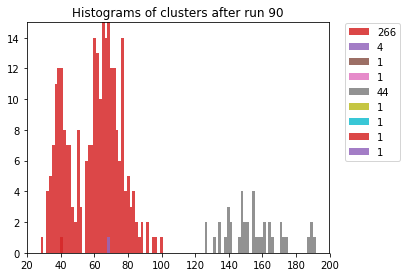

del 7 	 [266   4   1   1  44   1   1   0   1]
add 9 	 [266   4   1   1  44   1   1   1   1]
del 7 	 [266   4   1   1  44   1   1   0   1]
add 9 	 [266   4   1   1  44   1   1   1   1]


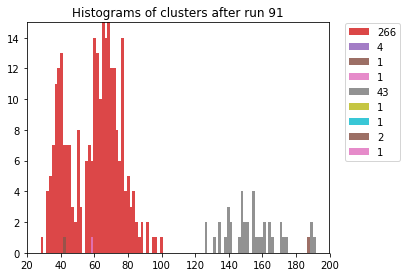

add 10 	 [265   4   1   1  43   1   1   2   1   1]
add 11 	 [264   4   1   1  43   1   1   2   1   1   1]
add 12 	 [263   4   1   1  44   1   1   1   1   1   1   1]
del 7 	 [262   4   1   1  45   1   1   0   1   1   1   1]


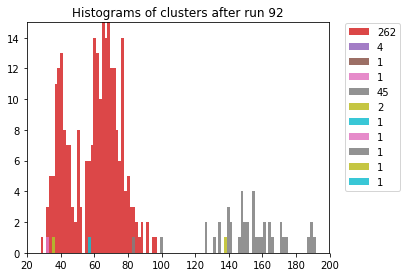

del 8 	 [262   4   1   1  45   2   1   1   0   1   1]
del 8 	 [263   4   1   1  45   2   1   1   0   1]
del 7 	 [264   4   1   1  45   2   1   0   1]
add 9 	 [261   4   1   1  48   2   1   1   1]
del 7 	 [260   4   1   1  49   2   1   0   1]
add 9 	 [258   4   1   1  51   2   1   1   1]
add 10 	 [259   6   1   1  47   2   1   1   1   1]


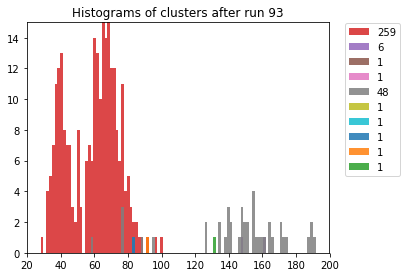

del 7 	 [262   6   1   1  45   1   1   0   1   1]
add 10 	 [261   6   1   1  46   1   1   1   1   1]
add 11 	 [260   6   1   1  46   1   1   1   1   1   1]
del 7 	 [260   6   1   1  46   1   1   0   1   1   1]
add 11 	 [259   6   1   1  47   1   1   1   1   1   1]


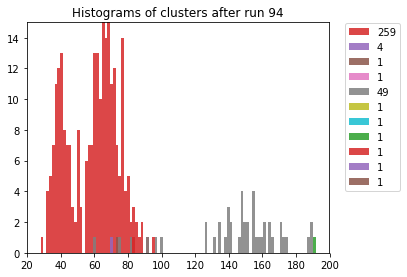

del 8 	 [259   4   1   1  49   1   1   1   0   1   1]
add 11 	 [258   4   1   1  49   1   1   1   2   1   1]
del 9 	 [258   4   1   1  49   1   1   1   2   0   1]
del 7 	 [258   4   1   1  50   1   1   0   2   1]


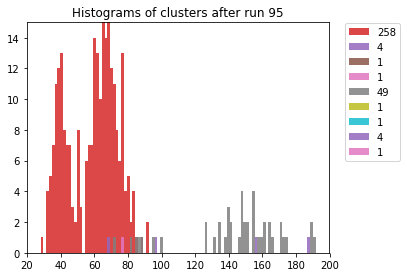

del 8 	 [257   4   1   1  49   1   1   5   0]


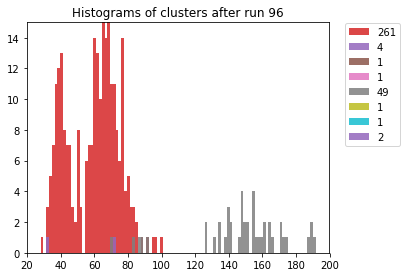

del 7 	 [261   4   1   1  50   1   1   0]


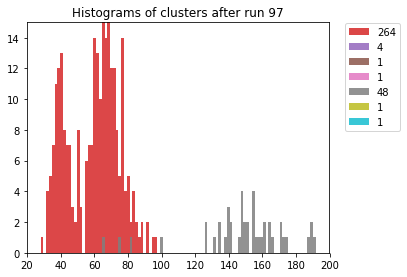

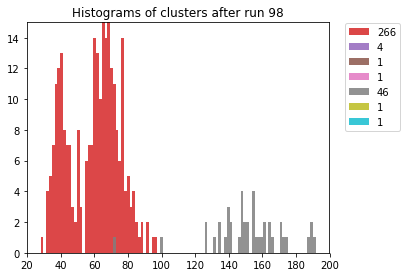

add 8 	 [265   4   1   1  46   1   1   1]
add 9 	 [264   4   1   1  46   1   1   1   1]
add 10 	 [261   4   1   1  47   1   1   2   1   1]
add 11 	 [261   4   1   1  46   1   1   2   1   1   1]


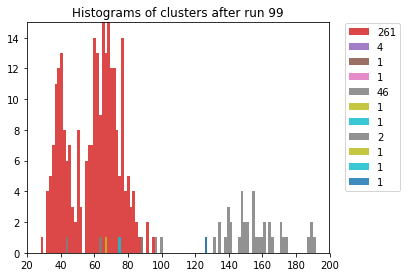

del 8 	 [263   4   1   1  45   1   1   1   0   1   1]
del 7 	 [264   4   1   1  45   1   1   0   1   1]
del 7 	 [267   4   1   1  43   1   1   0   1]
del 7 	 [268   5   1   1  42   1   1   0]


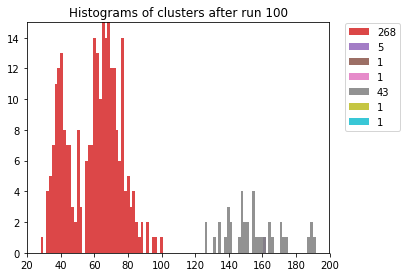

[59.943441664499758, -6.9952388688458703e+19, -1.7423855320896539e+33, 9.8213307980775112e+37, 2.6057494062930703e+20, -1.3966284980049199e+32, 3.9432198757659488e+38]
[15.088016332707642, 1798469226.080811, 27863231969437616.0, 1.3412343963384929e+18, 1785835064.7313054, 2420388476506931.0, 3.5963346252923279e+18]


In [63]:
mu0 = np.average(X);
lambda0 = 1;
alpha0 = 0.0625;
beta0 = np.var(X)*alpha0;
alpha_dp = 1;

cl_igmm_gibbs, mu, s = igmm_gibbs(X, 100, 20,alpha_dp,mu0,lambda0,alpha0,beta0);
print(mu);
print(s);

# Bonus: GMM with SciKit Learn

Here we train GMMs with Sklearn. I did not use this part for the lecture.
It seems like one can not set the priors for those models. 

I also played around with larger samples to help the DPGMM from SciKit, but obviously something in the implementation is wrong.

In [ ]:
gmm = mix.GMM(n_components=3);
X=np.array(X);
X_zip = [list(i) for i in zip(*[X])];
gmm.fit(X_zip,y);

In [ ]:
cl_gmm_gibbs_3 = gmm.predict(X_zip);
plt.hist(X[cl_gmm_gibbs_3 == 0],bins=bins);
plt.hist(X[cl_gmm_gibbs_3 == 1],bins=bins);
plt.hist(X[cl_gmm_gibbs_3 == 2],bins=bins);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);

print("mus:",gmm.means_);
print("sigmas", np.sqrt(gmm.covars_));

In [ ]:
n_comp=10;
dpgmm = mix.DPGMM(n_components=n_comp);
dpgmm.fit(X_zip,y);
cl_gmm_gibbs_5 = dpgmm.predict(X_zip);
legend_names = [];
for i in range(0,n_comp):
    plt.hist(X[cl_gmm_gibbs_5 == i],bins=bins);
    legend_names.append("Cluster %i"%i);
plt.legend(legend_names);
plt.show();
print("mus:",dpgmm.means_);

In [ ]:
c_len_2 = [8000,20000,4000];

X_2 = [];
y_2 = [];

for i in range(0,c):
    random_samples = stats.norm(c_mean[i],c_std[i]).rvs(c_len_2[i]);
    X_2.extend(random_samples);
    y_2.extend([i]*c_len_2[i]);

bins = np.linspace(min(X_2), max(X_2), 100)

y_2=np.array(y_2);
X_2=np.array(X_2);

plt.hist(X_2,bins=bins);
plt.show();

plt.hist(X_2[y_2 == 0],bins=bins);
plt.hist(X_2[y_2 == 1],bins=bins);
plt.hist(X_2[y_2 == 2],bins=bins);

plt.legend(["Group 1","Group 2", "Group 3"]);

In [ ]:
X_2=np.array(X_2);
X_2_zip = [list(i) for i in zip(*[X_2])];

dpgmm_2 = mix.DPGMM(n_components=3,alpha=3);
dpgmm_2.fit(X_2_zip,y);
cl_gmm_gibbs_6 = dpgmm_2.predict(X_2_zip);
print(dpgmm_2.n_components)
plt.hist(X_2[cl_gmm_gibbs_6 == 0],bins=bins,alpha=0.5);
plt.hist(X_2[cl_gmm_gibbs_6 == 1],bins=bins,alpha=0.5);
plt.hist(X_2[cl_gmm_gibbs_6 == 2],bins=bins,alpha=0.5);

plt.legend(["Cluster 1","Cluster 2", "Cluster 3"]);



print("mus:",dpgmm_2.means_);